# 微信数据统计分析

## 1. 导入依赖库

In [1]:
import pickle
import random
import os
from PIL import Image
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from wordcloud import WordCloud
import itchat
from threading import Thread as th
import jieba
import re
import json
from urllib.request import urlopen, quote
import webbrowser as web
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(style="white", context="notebook")
sns.set_style('whitegrid', {'font.sans-serif':['simhei', 'Arial']})

## 2. 登陆微信获取数据

In [10]:
itchat.auto_login(True)
friends = itchat.get_friends(update=True)
print('朋友数：\t', len(friends))

朋友数：	 705


## 3. 如果不能登录，则使用本地数据替代
如果上面已登录，则不要执行下面这个代码框，否则会覆盖你的数据

In [2]:
from urllib import request
import pickle

url = 'https://yooongchun-blog-v2.oss-cn-beijing.aliyuncs.com/media/friends.pickle'
file_stream = request.urlopen(url)  # 读取远程数据
friends = pickle.load(file_stream)
print('朋友数：\t', len(friends))

朋友数：	 705


## 4. 保存数据
将数据保存到本地，以后只需要使用下面加载数据的方式加载即可，不用再次登录

In [11]:
with open("friends.pickle","wb")as fp:
    pickle.dump(friends,fp)

## 5. 从本地加载数据

In [15]:
with open("friends.pickle","rb")as fp:
    friends=pickle.load(fp)

print("Total {} friends.".format(len(friends)))

Total 705 friends.


## 6. 获取城市数据
将城市、省份数据拼接，并且统计相应地区好友数

In [16]:
pro_city={}
for friend in friends:
    province=friend['Province']
    city=friend['City']
    pc=province+' '+city
    if pc in pro_city:
        pro_city[pc] += 1
    else:
        pro_city[pc] = 1
for addr, num in pro_city.items():
    print(f'{addr}\t{num}')

北京 东城	4
北京 海淀	35
England London	1
浙江 台州	1
上海 徐汇	8
 	199
天津 	2
上海 黄浦	4
云南 临沧	19
上海 普陀	2
四川 泸州	1
贵州 安顺	2
安徽 亳州	2
上海 闵行	49
上海 金山	1
四川 绵阳	1
广东 广州	14
天津 南开	2
湖北 武汉	9
浙江 温州	2
上海 浦东新区	14
山东 济南	4
湖南 衡阳	2
云南 昆明	9
浙江 宁波	3
上海 	18
福建 龙岩	1
辽宁 沈阳	3
北京 大兴	2
北京 朝阳	23
云南 普洱	1
云南 保山	1
浙江 杭州	9
Wan Chai 	1
江苏 无锡	3
四川 成都	16
安徽 阜阳	1
江西 上饶	2
广东 深圳	9
山东 青岛	6
Offaly 	1
广东 茂名	2
江西 南昌	2
山东 东营	1
江苏 南通	2
重庆 黔江	1
山东 潍坊	2
广西 防城港	1
重庆 大足	1
江苏 南京	8
北京 	14
上海 松江	3
湖南 长沙	3
福建 厦门	4
黑龙江 哈尔滨	4
Berlin 	1
河南 郑州	5
北京 丰台	2
陕西 西安	6
New South Wales Wollongong	1
天津 和平	1
云南 昭通	1
北京 昌平	3
广东 江门	1
山西 运城	1
Taoyuan County 	1
福建 泉州	4
吉林 延边	2
山东 济宁	3
福建 漳州	1
Longford 	1
山西 太原	3
New South Wales Sydney	1
湖南 岳阳	2
浙江 湖州	4
湖北 黄冈	2
河北 石家庄	3
河南 洛阳	2
Mantova 	1
Styria 	1
河北 邯郸	1
河南 濮阳	1
Queensland Brisbane	1
Stockholms 	1
陕西 	1
Dubayy 	1
Vorarlberg 	1
甘肃 兰州市	1
浙江 金华	2
福建 三明	1
云南 	1
重庆 江北	2
江苏 常州	3
内蒙古 乌兰察布	1
安徽 	1
福建 福州	3
内蒙古 包头	1
Kowloon City 	1
安徽 合肥	3
内蒙古 呼伦贝尔	1
Burgenland 	1
Addu Atoll 	1
上海 长宁	2
California Berkeley	1
重庆 巴南	1
Pennsylvania Pi

## 7. 下载头像

In [22]:
def download_icon(user_name, icon_name):
    img = itchat.get_head_img(userName=user_name)
    with open(icon_name, "wb") as fp:
        fp.write(img)

if not os.path.isdir("img"):
    os.mkdir("img")
t_pool=[]
print('Using multiple threads to download images...')
for index, friend in enumerate(friends):
    t=th(target=download_icon, args=(friend["UserName"], "img/{:0>3d}.jpg".format(index+1)))
    t.start()
    t_pool.append(t)

for index, t in enumerate(t_pool):
    print("\rProcessing：["+"="*(index//10)+">]"+"{:.2f}%".format((index+1)/len(friends)*100), end="", flush=True)
    t.join()
print("\nDownload images done.")

Using multiple threads to download images...
Processing：[======================================================================>]100.00%
Download images done.


## 8. 使用本地头像数据
如果你不能登录itchat，或者执行上面[下载头像]的代码报错，则使用本地头像数据

In [35]:
from urllib import request
import pickle
from io import BytesIO

url = 'https://yooongchun-blog-v2.oss-cn-beijing.aliyuncs.com/media/all-head-imgs.bytes.pickle'

file_stream = request.urlopen(url)  # 读取远程数据
all_head_imgs_bytes = pickle.load(file_stream)

print('头像数：', len(all_head_imgs_bytes))

头像数： 705


随机查看一张下载的头像图片

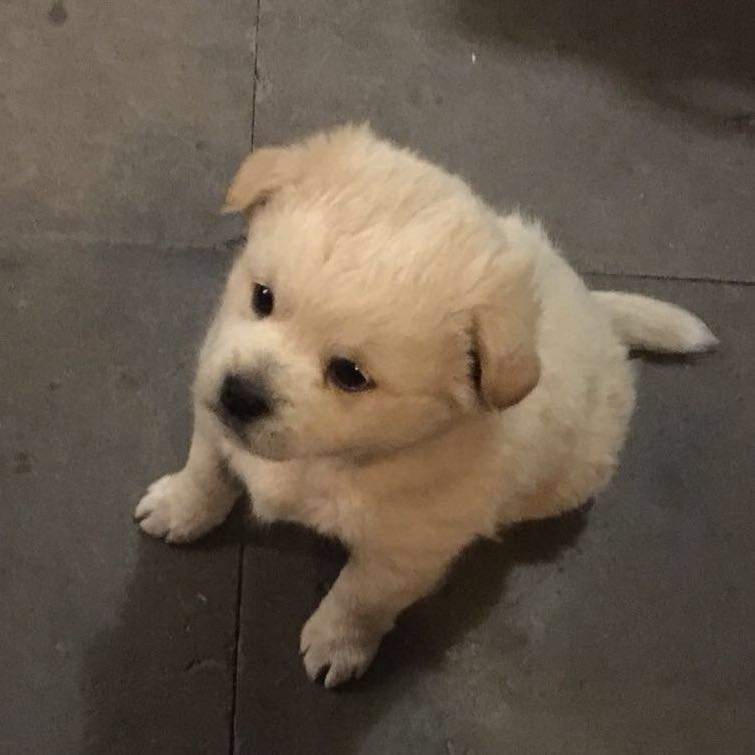

In [38]:
from PIL import Image
Image.open(BytesIO(all_head_imgs_bytes[15]))

将头像保存到img目录

In [43]:
DIR = 'img' # 保存目录

# 如果目录不存在，则创建
if not os.path.isdir(DIR):
    os.mkdir(DIR)
# 遍历保存图片
for idx, img_bytes in enumerate(all_head_imgs_bytes):
    path = DIR + '/' + '{0:>3}.jpg'.format(idx+1)
    with open(path, 'wb') as f:
        f.write(img_bytes)
    print("\r进度：["+"="*(idx//10)+">]"+"{:.2f}%".format((idx+1)/len(all_head_imgs_bytes)*100), end="", flush=True)

进度：[======================================================================>]100.00%

## 9. 拼接头像

In [44]:
def createImg():
    x = 0
    y = 0
    size=3000
    img_dir=os.path.abspath("img")
    imgs = [os.path.join(img_dir,img) for img in os.listdir(img_dir)]
    random.shuffle(imgs)
    new_img = Image.new('RGBA', (size, size))
    width = int(math.sqrt(size * size / len(imgs)))
    num_line = int(size / width)
    for index,img_path in enumerate(imgs):
        print("\rHandling：["+"="*(index//10)+">]"+"{:.2f}%".format((index+1)/len(imgs)*100),end="",flush=True)
        try:
            img = Image.open(img_path)
        except:
            continue
        img = img.resize((width, width), Image.ANTIALIAS)
        new_img.paste(img, (x * width, y * width))
        x += 1
        if x >= num_line:
            x = 0
            y += 1

    new_img.save("all.png")
    return new_img

im=createImg()
im.show()

Handling：[======================================================================>]100.00%

## 10. 性别比例分析

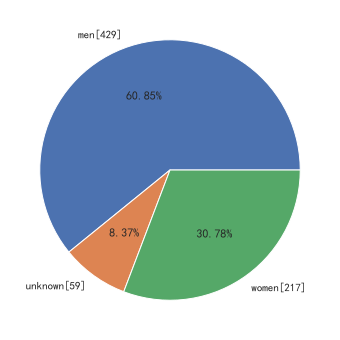

In [48]:
def getSex():
    sex = dict()
    for f in friends:
        if f["Sex"] == 1: # man
            sex["men"] = sex.get("men", 0) + 1
        elif f["Sex"] == 2: # women
            sex["women"] = sex.get("women", 0) + 1
        else: # unknown
            sex["unknown"] = sex.get("unknown", 0) + 1
    return sex
sex=getSex()
df=pd.DataFrame.from_dict(sex,orient="index",columns=["num"])
num=df["num"].values
text=df.index.tolist()
labels=list(map(lambda x: str(x[1])+"["+str(x[0])+"]", zip(num, text)))
plt.figure(figsize=(6,6))
plt.pie(df["num"],labels=labels,autopct="%3.2f%%")
plt.show()

## 11. 签名数据分析
词云展示

In [49]:
# 获取签名数据
def getSignature():
    with open('sign.txt', 'a', encoding='utf-8') as file:
        for f in friends:
            signature = f["Signature"].strip().replace("emoji", "").replace("span", "").replace("class", "")
            rec = re.compile("1f\d+\w*|[<>/=]")
            signature = rec.sub("", signature)
            file.write(signature + "\n")


# 创建词云展示
def create_word_cloud(filename):
    with open("{}.txt".format(filename), encoding='utf-8') as fp:
        text=fp.read()    
    text=re.sub(r"(\n)+","\n","\n".join(jieba.cut(text))) # 分词
    wc = WordCloud(
        background_color="white",
        max_words=2000,
        font_path='C:\\Windows\\Fonts\\simfang.ttf',
        height=1000,
        width=1000,
        max_font_size=80,
        random_state=50,
    )
    myword = wc.generate(text)
    wc.to_file('signature.png')
    os.system('start signature.png')
getSignature()
create_word_cloud("sign")

## 12. 好友地域分布分析

In [51]:
# 根据地名获得经纬度信息
def GetLngLat(address):
    url = 'http://api.map.baidu.com/geocoder/v2/'
    output = 'json'
    ak = 'x2ZTlRkWM2FYoQbvGOufPnFK3Fx4vFR1'
    add = quote(address)
    uri = url + '?' + 'address=' + add + '&output=' + output + '&ak=' + ak
    try:
        req = urlopen(uri)
    except ConnectionRefusedError as e:
        return e
    res = req.read().decode()
    temp = json.loads(res)  # 对json数据进行解析
    return temp

# 可视化热力图html代码
def html_code():
    head = '''<!DOCTYPE html>\n<html>\n<head>\n    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n    <meta name="viewport" content="initial-scale=1.0, user-scalable=no" />\n    <script type="text/javascript" src="http://gc.kis.v2.scr.kaspersky-labs.com/C8BAC707-C937-574F-9A1F-B6E798DB62A0/main.js" charset="UTF-8"></script><script type="text/javascript" src="http://api.map.baidu.com/api?v=2.0&ak=x2ZTlRkWM2FYoQbvGOufPnFK3Fx4vFR1"></script>\n    <script type="text/javascript" src="http://api.map.baidu.com/library/Heatmap/2.0/src/Heatmap_min.js"></script>\n    <title>热力图功能示例</title>\n    <style type="text/css">\n		ul,li{list-style: none;margin:0;padding:0;float:left;}\n		html{height:100%}\n		body{height:100%;margin:0px;padding:0px;font-family:"微软雅黑";}\n		#container{height:100%;width:100%;}\n		#r-result{width:100%;}\n    </style>	\n</head>\n<body>\n	<div id="container"></div>\n	<div id="r-result">\n		<input type="button"  onclick="openHeatmap();" value="显示热力图"/><input type="button"  onclick="closeHeatmap();" value="关闭热力图"/>\n	</div>\n</body>\n</html>\n<script type="text/javascript">\n    var map = new BMap.Map("container");          // 创建地图实例\n\n    var point = new BMap.Point(105.418261, 35.921984);\n    map.centerAndZoom(point, 5);             // 初始化地图，设置中心点坐标和地图级别\n    map.enableScrollWheelZoom(); // 允许滚轮缩放\n  \n    var points =['''
    rear = ''']\n   \n    if(!isSupportCanvas()){\n    	alert('热力图目前只支持有canvas支持的浏览器,您所使用的浏览器不能使用热力图功能~')\n    }\n	//详细的参数,可以查看heatmap.js的文档 https://github.com/pa7/heatmap.js/blob/master/README.md\n	//参数说明如下:\n	/* visible 热力图是否显示,默认为true\n     * opacity 热力的透明度,1-100\n     * radius 势力图的每个点的半径大小   \n     * gradient  {JSON} 热力图的渐变区间 . gradient如下所示\n     *	{\n			.2:'rgb(0, 255, 255)',\n			.5:'rgb(0, 110, 255)',\n			.8:'rgb(100, 0, 255)'\n		}\n		其中 key 表示插值的位置, 0~1. \n		    value 为颜色值. \n     */\n	heatmapOverlay = new BMapLib.HeatmapOverlay({"radius":20});\n	map.addOverlay(heatmapOverlay);\n	heatmapOverlay.setDataSet({data:points,max:10});\n	//是否显示热力图\n    function openHeatmap(){\n        heatmapOverlay.show();\n    }\n	function closeHeatmap(){\n        heatmapOverlay.hide();\n    }\n	openHeatmap();\n    function setGradient(){\n     	/*格式如下所示:\n		{\n	  		0:'rgb(102, 255, 0)',\n	 	 	.5:'rgb(255, 170, 0)',\n		  	1:'rgb(255, 0, 0)'\n		}*/\n     	var gradient = {};\n     	var colors = document.querySelectorAll("input[type='color']");\n     	colors = [].slice.call(colors,0);\n     	colors.forEach(function(ele){\n			gradient[ele.getAttribute("data-key")] = ele.value; \n     	});\n        heatmapOverlay.setOptions({"gradient":gradient});\n    }\n	//判断浏览区是否支持canvas\n    function isSupportCanvas(){\n        var elem = document.createElement('canvas');\n        return !!(elem.getContext && elem.getContext('2d'));\n    }\n</script>'''

    return head, rear
def view_map(pro_city):
    # 显示城市分布,使用百度的api获得相应城市的经纬度，然后使用heatmap.json生成热力图，返回html文件
    json_data = ''
    # 把城市数据转为经纬度
    for city, value in pro_city.items():
        try:
            pos = GetLngLat(city)
        except ConnectionError:
            pos = None
        if pos is not None and pos['status'] == 0:
            lng = pos['result']['location']['lng']
            lat = pos['result']['location']['lat']
            json_temp = '{"lng":' + str(lng) + ',"lat":' + str(lat) + ', "count":' + str(value) + '}, '
            json_data += '\n' + json_temp

    # 生成html格式热力图文件
    try:
        head, rear = html_code()
        html_file = head + json_data + rear
        with open('heatmap.html', 'w', encoding='utf-8') as f:
            f.write(html_file)
            # 网页显示
            web.open('heatmap.html', new=0, autoraise=True)
    except AttributeError:
        return AttributeError

view_map(pro_city)